This is a starter notebook for the project, you'll have to import the libraries you'll need, you can find a list of the ones available in this workspace in the requirements.txt file in this workspace. 

# Step 0: Load the Vocareum Key and Initialize the Model

In [1]:
from src.vocareum import load_vocareum_key


load_vocareum_key()

Loaded API key: /home/efigueira/Desktop/udacity-genai-course4-real-state-agent-project/vocareum_key


# Step 1: Setting Up the Python Application and Load the Model

In [2]:
from src.model import Model, ImageGenerator
from src.schemas import PropertyDetails, print_schemas, CreateRealEstateListingsPrompt
from src.read_write_ops import save_df_in_csv, read_df_from_csv

from pathlib import Path

In [3]:
llm = Model().llm

# Step 2: Generating Real Estate Listings

We used an LLM (Language Model) to generate diverse property descriptions. Once these descriptions were created, we utilized them to generate corresponding images using the model "runwayml/stable-diffusion-v1-5", a text-to-image generation model. This allowed us to pair each listing's detailed description with a visually representative image.

In [4]:
property_example = PropertyDetails(
    neighborhood="Green Oaks",
    price=800000,
    bedrooms=3,
    bathrooms=2,
    house_size=2000,
    description="Welcome to this eco-friendly oasis nestled in the heart of Green Oaks. This charming 3-bedroom, 2-bathroom home boasts energy-efficient features such as solar panels and a well-insulated structure. Natural light floods the living spaces, highlighting the beautiful hardwood floors and eco-conscious finishes. The open-concept kitchen and dining area lead to a spacious backyard with a vegetable garden, perfect for the eco-conscious family. Embrace sustainable living without compromising on style in this Green Oaks gem.",
    neighborhood_description="Green Oaks is a close-knit, environmentally-conscious community with access to organic grocery stores, community gardens, and bike paths. Take a stroll through the nearby Green Oaks Park or grab a cup of coffee at the cozy Green Bean Cafe. With easy access to public transportation and bike lanes, commuting is a breeze."
)
property_example_text = print_schemas(property_example)

neighborhood: Green Oaks
price: 800000
bedrooms: 3
bathrooms: 2
house_size: 2000
description: Welcome to this eco-friendly oasis nestled in the heart of Green Oaks. This charming 3-bedroom, 2-bathroom home boasts energy-efficient features such as solar panels and a well-insulated structure. Natural light floods the living spaces, highlighting the beautiful hardwood floors and eco-conscious finishes. The open-concept kitchen and dining area lead to a spacious backyard with a vegetable garden, perfect for the eco-conscious family. Embrace sustainable living without compromising on style in this Green Oaks gem.
neighborhood_description: Green Oaks is a close-knit, environmentally-conscious community with access to organic grocery stores, community gardens, and bike paths. Take a stroll through the nearby Green Oaks Park or grab a cup of coffee at the cozy Green Bean Cafe. With easy access to public transportation and bike lanes, commuting is a breeze.


In [5]:
real_state_csv_path = Path("real_estate_listings.csv")

In [6]:
def add_generated_images_to_listings(real_state_df):
    for index, row in real_state_df.iterrows():
        try:
            output_path = f"property_{index}.png"
            image_gen = ImageGenerator(row["description"], output_path)
            real_state_df.loc[index, "image_path"] = image_gen.img_path
            image_gen.generate()
        except Exception as e:
            ValueError(f"Failed to generate image for row {index}: {e}")
    return real_state_df

In [7]:
if real_state_csv_path.exists():
    df = read_df_from_csv(real_state_csv_path)
else:
    real_state_listings_prompt = CreateRealEstateListingsPrompt()
    query = real_state_listings_prompt.prepare_query(property_example_text=property_example_text)
    response = llm.invoke(query)
    df = real_state_listings_prompt.convert_response_to_df(response)
    df = add_generated_images_to_listings(df)
    save_df_in_csv(df, real_state_csv_path)

In [8]:
df.head(3)

,neighborhood,price,bedrooms,bathrooms,house_size,description,neighborhood_description,image_path
0,Green Oaks,800000,3,2,2000,Welcome to this eco-friendly oasis nestled in ...,"Green Oaks is a close-knit, environmentally-co...",/home/efigueira/Desktop/udacity-genai-course4-...
1,Sunset Hills,1200000,4,3,3000,Luxury living awaits in this stunning 4-bedroo...,Sunset Hills is an upscale community known for...,/home/efigueira/Desktop/udacity-genai-course4-...
2,Lakeview Terrace,600000,2,2,1800,"Welcome to this charming 2-bedroom, 2-bathroom...",Lakeview Terrace is a peaceful lakeside commun...,/home/efigueira/Desktop/udacity-genai-course4-...


# Step 3: Storing Listings in a Vector Database

We stored the information from the property descriptions and their corresponding images as embeddings in a ChromaDB database. To calculate the embeddings, we used the OpenCLIPEmbeddingFunction, allowing us to leverage both the textual descriptions and the images for similarity searches and future queries.

In [9]:
from src.vector_db import RAGWithChromaClipEmbeddings

In [10]:
chroma_db = RAGWithChromaClipEmbeddings(df)

✅ Collection 'real_state_collection' already exists. Skipping creation.


In [11]:
result = chroma_db.query_db('A quiet neighborhood, good local schools, and convenient shopping options.', 1)


🏡 1. House Suggestion (Distance: 1.4762)
neighborhood: Lakeview Terrace
price: 600000
bedrooms: 2
bathrooms: 2
house_size: 1800
description: Welcome to this charming 2-bedroom, 2-bathroom cottage in the scenic Lakeview Terrace neighborhood. The cozy interior features vaulted ceilings, a stone fireplace, and a sunroom overlooking the tranquil lake. Step outside to the spacious deck and lush backyard, perfect for outdoor entertaining. This is lakeside living at its finest in Lakeview Terrace.
neighborhood_description: Lakeview Terrace is a peaceful lakeside community known for its picturesque views, nature trails, and water sports activities. Residents can enjoy fishing, boating, and kayaking on the lake, or simply relax and take in the serene surroundings. Experience the beauty of nature in Lakeview Terrace.


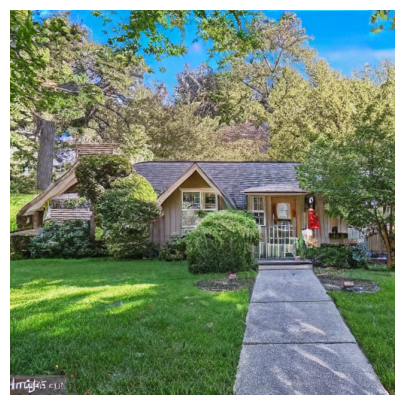

In [12]:
chroma_db.display_query_results()

# Step 4: Building the User Preference Interface

This step collects buyer preferences for a property using an AI-driven interactive assistant. The assistant asks predefined questions about the buyer's requirements. The AI listens to responses, stores them in memory, and generates a concise summary of the buyer's needs.

In [13]:
from src.real_state_agent import BuyerCollectorPreferences

In [14]:
collector = BuyerCollectorPreferences(llm=llm)

/home/efigueira/Desktop/udacity-genai-course4-real-state-agent-project/src/real_state_agent/buyer_collector_preferences.py:25: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  self.memory = ConversationBufferMemory()
/home/efigueira/Desktop/udacity-genai-course4-real-state-agent-project/src/real_state_agent/buyer_collector_preferences.py:27: LangChainDeprecationWarning: The class `ConversationChain` was deprecated in LangChain 0.2.7 and will be removed in 1.0. Use :meth:`~RunnableWithMessageHistory: https://python.langchain.com/v0.2/api_reference/core/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html` instead.
  self.conversation_chain = ConversationChain(


In [15]:
collector.collect()

LLM Setup: Setting the context for the assistant.


/home/efigueira/Desktop/udacity-genai-course4-real-state-agent-project/src/real_state_agent/buyer_collector_preferences.py:49: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  self.conversation_chain.run(setup_message.strip())


LLM (Question): How big do you want your house to be?
User (Answer): A comfortable three-bedroom house with a spacious kitchen and a cozy living room.
LLM (Response): Got it! You are looking for a comfortable three-bedroom house with a spacious kitchen and a cozy living room. Thank you for sharing your preference.

LLM (Question): What are the 3 most important things for you in choosing a property?
User (Answer): A quiet neighborhood, good local schools, and convenient shopping options.
LLM (Response): Got it! The 3 most important things for you in choosing a property are a quiet neighborhood, good local schools, and convenient shopping options. Thank you for providing your priorities.

LLM (Question): Which amenities would you like?
User (Answer): A backyard for gardening, a two-car garage, and a modern, energy-efficient heating system.
LLM (Response): Got it! You would like amenities such as a backyard for gardening, a two-car garage, and a modern, energy-efficient heating system. Th

/home/efigueira/Desktop/udacity-genai-course4-real-state-agent-project/src/real_state_agent/buyer_collector_preferences.py:89: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=self.llm, prompt=prompt)


'neighborhood: \nprice: \nbedrooms: 3\nbathrooms: \nhouse_size: \ndescription: The buyer is looking for a comfortable three-bedroom house in a quiet neighborhood with good local schools and convenient shopping options. They also prefer a backyard for gardening, a two-car garage, and a modern, energy-efficient heating system. Easy access to a reliable bus line, proximity to a major highway, and bike-friendly roads are important transportation options. The buyer seeks a neighborhood that balances suburban tranquility with access to urban amenities like restaurants and theaters.'

In [16]:
collector.summary

'neighborhood: \nprice: \nbedrooms: 3\nbathrooms: \nhouse_size: \ndescription: The buyer is looking for a comfortable three-bedroom house in a quiet neighborhood with good local schools and convenient shopping options. They also prefer a backyard for gardening, a two-car garage, and a modern, energy-efficient heating system. Easy access to a reliable bus line, proximity to a major highway, and bike-friendly roads are important transportation options. The buyer seeks a neighborhood that balances suburban tranquility with access to urban amenities like restaurants and theaters.'

Using the summarized information, we can now query the database containing our property details.


🏡 1. House Suggestion (Distance: 1.4454)
neighborhood: Green Oaks
price: 800000
bedrooms: 3
bathrooms: 2
house_size: 2000
description: Welcome to this eco-friendly oasis nestled in the heart of Green Oaks. This charming 3-bedroom, 2-bathroom home boasts energy-efficient features such as solar panels and a well-insulated structure. Natural light floods the living spaces, highlighting the beautiful hardwood floors and eco-conscious finishes. The open-concept kitchen and dining area lead to a spacious backyard with a vegetable garden, perfect for the eco-conscious family. Embrace sustainable living without compromising on style in this Green Oaks gem.
neighborhood_description: Green Oaks is a close-knit, environmentally-conscious community with access to organic grocery stores, community gardens, and bike paths. Take a stroll through the nearby Green Oaks Park or grab a cup of coffee at the cozy Green Bean Cafe. With easy access to public transportation and bike lanes, commuting is a bre

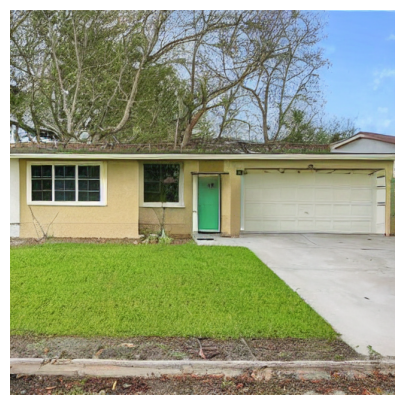


🏡 2. House Suggestion (Distance: 1.4583)
neighborhood: Lakeview Terrace
price: 600000
bedrooms: 2
bathrooms: 2
house_size: 1800
description: Welcome to this charming 2-bedroom, 2-bathroom cottage in the scenic Lakeview Terrace neighborhood. The cozy interior features vaulted ceilings, a stone fireplace, and a sunroom overlooking the tranquil lake. Step outside to the spacious deck and lush backyard, perfect for outdoor entertaining. This is lakeside living at its finest in Lakeview Terrace.
neighborhood_description: Lakeview Terrace is a peaceful lakeside community known for its picturesque views, nature trails, and water sports activities. Residents can enjoy fishing, boating, and kayaking on the lake, or simply relax and take in the serene surroundings. Experience the beauty of nature in Lakeview Terrace.


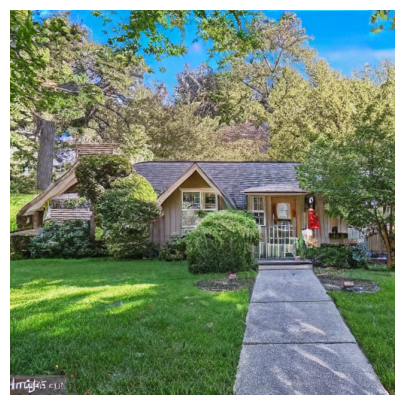


🏡 3. House Suggestion (Distance: 1.4588)
neighborhood: Meadowbrook Heights
price: 650000
bedrooms: 4
bathrooms: 3
house_size: 2400
description: Step into luxury in this spacious 4-bedroom, 3-bathroom home in the desirable Meadowbrook Heights neighborhood. The open floor plan features a gourmet kitchen, formal dining room, and sun-filled living room with a fireplace. Step outside to the patio and landscaped yard, perfect for outdoor entertaining. This is the perfect place to call home in Meadowbrook Heights.
neighborhood_description: Meadowbrook Heights is a family-friendly neighborhood with tree-lined streets, parks, and community events. Residents enjoy easy access to schools, playgrounds, and local shops, creating a welcoming and close-knit community atmosphere. Experience the best of suburban living in Meadowbrook Heights.


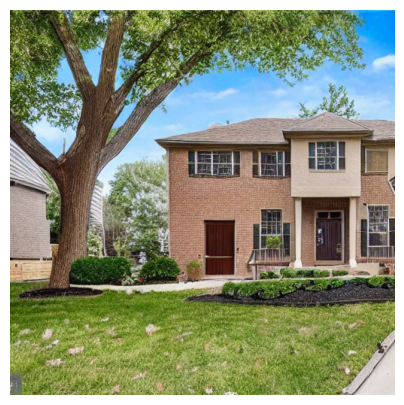

In [17]:
result = chroma_db.query_db(collector.summary, 3)
chroma_db.display_query_results()

# Step 5: Searching Based on Preferences

This step is included at the end of Step 4.

# Step 6: Personalizing Listing Descriptions

For each retrieved listing, the LLM tailors the property description to emphasize features that align with the buyer’s preferences, enhancing its appeal. The process strictly maintains factual integrity, ensuring no factual details are altered or invented.

In [18]:
from src.real_state_agent import ListingAugmenter

In [19]:
augmented_listings = ListingAugmenter(llm).process(chroma_db.query_results, collector.summary)

Based on your preferences, here some suggestions:
Welcome to this eco-friendly oasis nestled in the heart of Green Oaks, the perfect neighborhood for those seeking suburban tranquility with access to urban amenities. This charming 3-bedroom, 2-bathroom home is ideal for the eco-conscious buyer, featuring energy-efficient solar panels and a well-insulated structure. Natural light floods the living spaces, showcasing the beautiful hardwood floors and eco-conscious finishes.

The open-concept kitchen and dining area lead to a spacious backyard, perfect for gardening enthusiasts. The backyard includes a vegetable garden, providing the perfect space for cultivating your own produce. Embrace sustainable living without compromising on style in this Green Oaks gem.

Green Oaks is a close-knit, environmentally-conscious community with access to organic grocery stores, community gardens, and bike paths. Enjoy easy access to a reliable bus line and bike-friendly roads, making commuting a breeze. 

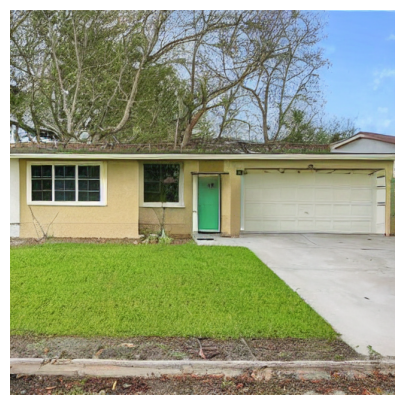


-------------------------------------

Welcome to this charming 3-bedroom, 2-bathroom cottage in the serene Lakeview Terrace neighborhood. This comfortable home offers a cozy interior with vaulted ceilings, a stone fireplace, and a sunroom that overlooks the tranquil lake. The spacious deck and lush backyard provide the perfect space for gardening and outdoor relaxation. Additionally, the two-car garage offers ample storage for all your needs.

Lakeview Terrace is a quiet neighborhood with good local schools and convenient shopping options nearby. The property also boasts a modern, energy-efficient heating system, ensuring comfort and sustainability. With easy access to a reliable bus line and proximity to a major highway, transportation options are convenient for daily commutes. The neighborhood's bike-friendly roads make it easy to explore the area and enjoy the suburban tranquility while still having access to urban amenities like restaurants and theaters.

Don't miss out on the op

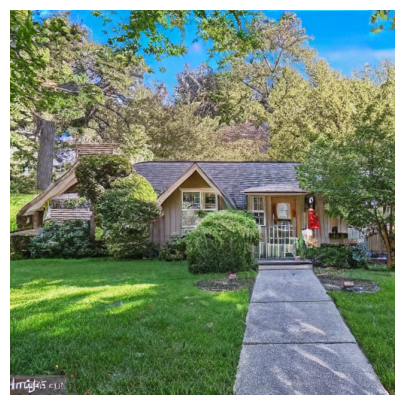


-------------------------------------

Step into luxury in this spacious 4-bedroom, 3-bathroom home located in the desirable Meadowbrook Heights neighborhood. This family-friendly neighborhood boasts tree-lined streets, parks, and community events, creating a welcoming and close-knit community atmosphere. Residents enjoy easy access to schools, playgrounds, and local shops, making it the perfect place for a comfortable family life. The open floor plan features a gourmet kitchen, formal dining room, and sun-filled living room with a fireplace, ideal for cozy gatherings. Step outside to the patio and landscaped yard, perfect for outdoor entertaining and gardening. Additionally, this home includes a two-car garage for convenient parking and a modern, energy-efficient heating system for added comfort. Meadowbrook Heights offers a balance of suburban tranquility with access to urban amenities like restaurants and theaters, providing the best of both worlds. Don't miss out on the opportunit

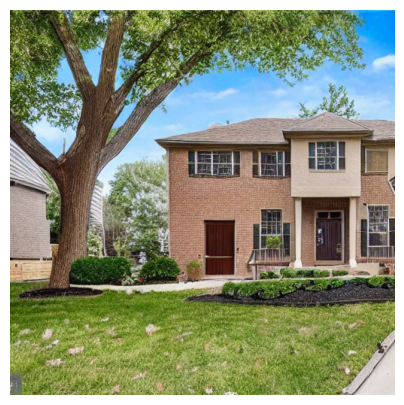


-------------------------------------



In [20]:
print('Based on your preferences, here some suggestions:')
for augmented_l, chroma_result in zip(augmented_listings, chroma_db.query_results):
    print(augmented_l.content)
    chroma_db.display_result(chroma_result)
    print('\n-------------------------------------\n')